### Case Study: COVID-19 Evolution in Mexico City & Correlation with Proximity Retailing Activity

##### 0.0 - Section Description

insert description!!!

##### 0.1 - Libraries, API keys, Configuration & Data Loading



In [485]:
#Libraries
import pandas as pd
import numpy as np
import geopandas as gpd #GIS dependency for spatial data manipulation
from datetime import datetime
import matplotlib.pyplot as plt
import requests

#API keys
from api_keys import gkey

#Data
covid = pd.read_csv("Resources/covid_19_por_colonia_y_fecha.csv") #Covid cases by neighbourghood (Mexico City)
colonias = gpd.read_file("Resources/coloniascdmx/coloniascdmx.shp") #Shapefile w/ Mexico City neighbourhoods

##### 1.1 Cleaning & Descriptive Data Analysis

In [217]:
#Basic exploration of Covid df
#The df contains observations of active covid-19 cases by Mexico City Neighbourhood since the beginning of the Pandemic.
covid = covid.rename(columns= {"Clave" : "cve_col"})
len(covid) #over 84,000 observations
len(covid["cve_col"].unique()) #1496 unique neighbourhoods
len(covid["Fecha"].unique()) #184 days reported
184*1496 #Not entries for all neighbourhoods at all days (otherwise we should have a 275,000 row df)
covid.head()

,cve_col,Fecha,Casos positivos
0,05-011,200630,6
1,05-011,200903,8
2,05-011,200904,8
3,05-011,200905,7
4,05-011,200906,7


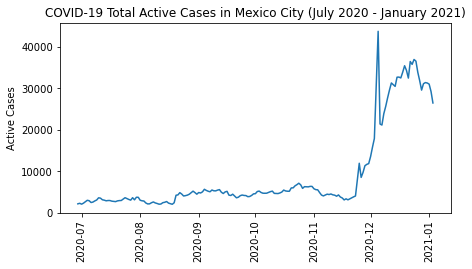

In [218]:
#Evolution of total active cases in Mexico City over time.
#group total cases by date
covid_grouped = pd.DataFrame({"Total Cases" : covid.groupby("Fecha")["Casos positivos"].sum()}).reset_index()
covid_grouped["Fecha"] = pd.to_datetime(covid_grouped["Fecha"], format= "%y%m%d")

#plotting
plt.figure(figsize= [7,3.5])
plt.plot(covid_grouped["Fecha"], covid_grouped["Total Cases"])
plt.title("COVID-19 Total Active Cases in Mexico City (July 2020 - January 2021)")
plt.ylabel("Active Cases")
plt.xticks(rotation='vertical')
plt.show()

+proj=lcc +lat_1=17.5 +lat_2=29.5 +lat_0=12 +lon_0=-102 +x_0=2500000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +type=crs


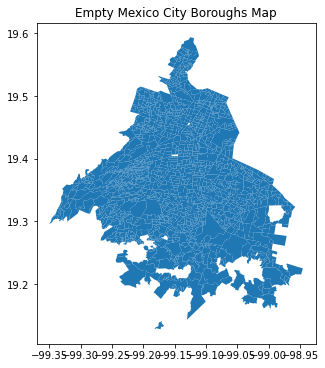

In [219]:
#Mexico City Map
colonias = colonias.set_crs("+proj=lcc +lat_1=17.5 +lat_2=29.5 +lat_0=12 +lon_0=-102 +x_0=2500000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m")
print(colonias.crs)
colonias.plot(figsize= [5,10])
plt.title("Empty Mexico City Boroughs Map")
plt.show()

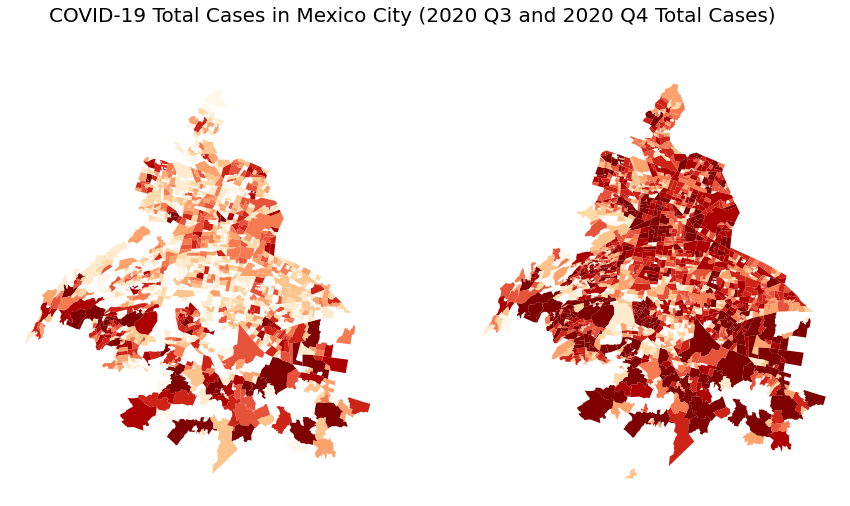

In [296]:
#Covid19 2020 Q3 aggregated cases
covidQ3 = covid.loc[(covid["Fecha"] >= 200701) & (covid["Fecha"] < 201001),]
covidQ3.head()
covidQ3 = covidQ3.groupby("cve_col")["Casos positivos"].agg(["sum", "mean", "max", "min"])
covidQ3.head()

#Covid19 2020 Q4 aggregated cases
covidQ4 = covid.loc[(covid["Fecha"] >= 201001) & (covid["Fecha"] < 210101),]
covidQ4.head()
covidQ4 = covidQ4.groupby("cve_col")["Casos positivos"].agg(["sum", "mean", "max", "min"])
covidQ4.head()

#colonias merging gpd w/ covid Q3 series
coloniasQ3 = pd.merge(colonias, covidQ3, on= "cve_col", how= "left")
coloniasQ3 = coloniasQ3.drop(columns= ["nombre", "entidad", "cve_alc", "secc_com", "secc_par"])
coloniasQ3.head()

#colonias merging gpd w/ covid Q3 series
coloniasQ4 = pd.merge(colonias, covidQ4, on= "cve_col", how= "left")
coloniasQ4 = coloniasQ4.drop(columns= ["nombre", "entidad", "cve_alc", "secc_com", "secc_par"])
coloniasQ4.head()

#Creating Quantiles
a = pd.qcut(np.concatenate((coloniasQ3["sum"], coloniasQ4["sum"]), axis= None), 10, labels= False)
coloniasQ3["cut"] = a[:len(a)//2]
coloniasQ4["cut"] = a[len(a)//2:]

#Plotting Cases
fig1, axs = plt.subplots(1,2, figsize=(15,8))
fig1.suptitle("COVID-19 Total Cases in Mexico City (2020 Q3 and 2020 Q4 Total Cases)", size= 20)
coloniasQ3.plot(column= "cut", ax= axs[0], cmap= "OrRd")
coloniasQ4.plot(column= "cut", ax= axs[1], cmap= "OrRd")
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[1].set_axis_off()
plt.show()

Cases have gone significantly up during the las quarter of 2020. While in Q3, the boroughs with more cases where concentrated in the South of Mexico City and there where still many boroughs without reported cases, in the last quarter of the year practically all central areas of the city where impacted by a rise of Covid-19 cases, specially central areas. Now we want to verify and contrast if there is a correlation with economic activity.

##### 1.2 Looking for "tianguis" in Google Places API

The "tianguis" or local market in Mexico City is practically a long established institution. Groceries, Clothing, food, etc. are sold in local street markets on a particular day of the week. Thouthands of residents of the borough make their weekly shopping in their local "tianguis". However, those open street markets do not meet necessary social distancing measures and are supposed to be perfect places for Covid 19 transmission. Of course, open street market activities were immediately impacted by the pandemic, as shoppers shifted to other forms of grocery shopping. However, these places are still operational and highly populated, and we could potentially stablish a hypothetical correlation between  "tianguis" popoularity and covid19 cases reported in the borough where the "tianguis" takes place.

In [473]:
#Getting "tianguis" data from Google Places --> EXECUTE JUST ONE TIME!!!

#sampling bouroughs (1812 to a just 100 to reduce amount of google queries)
sample_colonias = coloniasQ4.sample(n= 100)
sample_colonias = sample_colonias.reset_index()
sample_colonias

#Looping over boroughs to find tianguis
name = []
vicinity = []
rating = []
user_ratings_total = []
lng = []
lat = []

url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

for i in range(0,len(sample_colonias)):
    params = {
    "location": f'{sample_colonias["geometry"].centroid[[i]].y[i]}, {sample_colonias["geometry"].centroid[[i]].x[i]}',
    "keyword": "Tianguis",
    "radius": 5000,
    "key": gkey
    }
    response = requests.get(url, params= params).json()
    try:
        print(f'Looking for tianguis in query {i} - CVE COL: {sample_colonias.iloc[i,3]}.')
        
        for j in range(0, len(response["results"])):
            name.append(response["results"][j]["name"])
            vicinity.append(response["results"][j]["vicinity"])
            rating.append(response["results"][j]["rating"])
            user_ratings_total.append(response["results"][j]["user_ratings_total"])
            lng.append(response["results"][j]["geometry"]["location"]["lng"])
            lat.append(response["results"][j]["geometry"]["location"]["lat"])      
    except:
        print(f"(!!) Some information not found: query{i} CVE COL: {sample_colonias.iloc[i,3]}")
        pass
    print("-----------------------------------------")

#Creating a Tianguis dataframe
tianguis = pd.DataFrame({
    "name" : name,
    "vicinity" : vicinity,
    "rating" : rating,
    "Users_ratings_total": user_ratings_total,
    "lng" : lng,
    "lat" : lat
})

Looking for tianguis in query 0 - CVE COL: 10-002.
-----------------------------------------
Looking for tianguis in query 1 - CVE COL: 05-190.
-----------------------------------------
Looking for tianguis in query 2 - CVE COL: 05-115.
-----------------------------------------
Looking for tianguis in query 3 - CVE COL: 15-046.
-----------------------------------------
Looking for tianguis in query 4 - CVE COL: 07-315.
-----------------------------------------
Looking for tianguis in query 5 - CVE COL: 11-013.
-----------------------------------------
Looking for tianguis in query 6 - CVE COL: 14-042.
-----------------------------------------
Looking for tianguis in query 7 - CVE COL: 05-208.
-----------------------------------------
Looking for tianguis in query 8 - CVE COL: 15-006.
-----------------------------------------
Looking for tianguis in query 9 - CVE COL: 02-091.
-----------------------------------------
Looking for tianguis in query 10 - CVE COL: 17-070.
------------------

Looking for tianguis in query 88 - CVE COL: 07-091.
-----------------------------------------
Looking for tianguis in query 89 - CVE COL: 06-045.
-----------------------------------------
Looking for tianguis in query 90 - CVE COL: 10-121.
-----------------------------------------
Looking for tianguis in query 91 - CVE COL: 16-094.
-----------------------------------------
Looking for tianguis in query 92 - CVE COL: 05-016.
-----------------------------------------
Looking for tianguis in query 93 - CVE COL: 12-117.
-----------------------------------------
Looking for tianguis in query 94 - CVE COL: 15-029.
-----------------------------------------
Looking for tianguis in query 95 - CVE COL: 12-145.
-----------------------------------------
Looking for tianguis in query 96 - CVE COL: 17-037.
-----------------------------------------
Looking for tianguis in query 97 - CVE COL: 05-003.
-----------------------------------------
Looking for tianguis in query 98 - CVE COL: 03-088.
--------

In [482]:
#DISASTER COPY
tianguis
tianguis_copy = tianguis
tianguis_copy= tianguis_copy.drop_duplicates()
tianguis_copy.to_csv("Results/tianguis_df.csv")

In [492]:
#Tianguis heatmap
import plotly.express as px


ModuleNotFoundError: No module named 'plotly'